# Twitter Sentiment Analysis

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [68]:
# DATASET
DATASET_COLUMNS = ["text","target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300

W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 30
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
#SOMEWHAT_POSITIVE = "SOMEWHAT_POSITIVE"
NEGATIVE = "NEGATIVE"
#NEUTRAL = "NEUTRAL"
#SOMEWHAT_NEGATIVE ="SOMEWHAT_NEGATIVE" 
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

In [7]:
# Import pandas package
import pandas as pd

path =r"/kaggle/input/8552555j/movie.csv"

df.rename(columns = {"ï»¿text":"text","label":"target"}, inplace = True)

In [6]:

df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [19]:
df.rename(columns = {"ï»¿text":"text","label":"target"}, inplace = True)
df.tail(5)

,text,target
39996,"""Western Union"" is something of a forgotten cl...",1
39997,This movie is an incredible piece of work. It ...,1
39998,My wife and I watched this movie because we pl...,0
39999,"When I first watched Flatliners, I was amazed....",1
40000,"Why would this film be so good, but only gross...",1


In [18]:
df.loc[df["target"].str.contains('POSITIVE')]

,text,target


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [22]:
decode_map = {0: "NEGATIVE" , 10: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:

df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

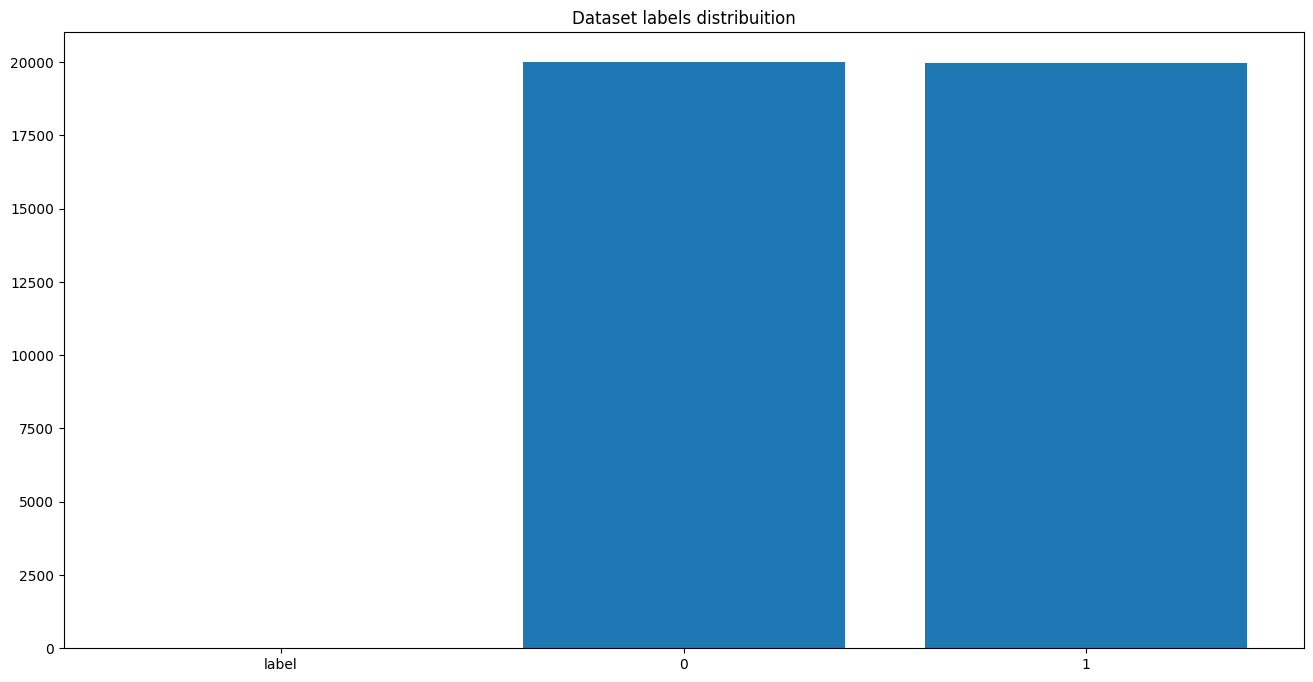

In [69]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

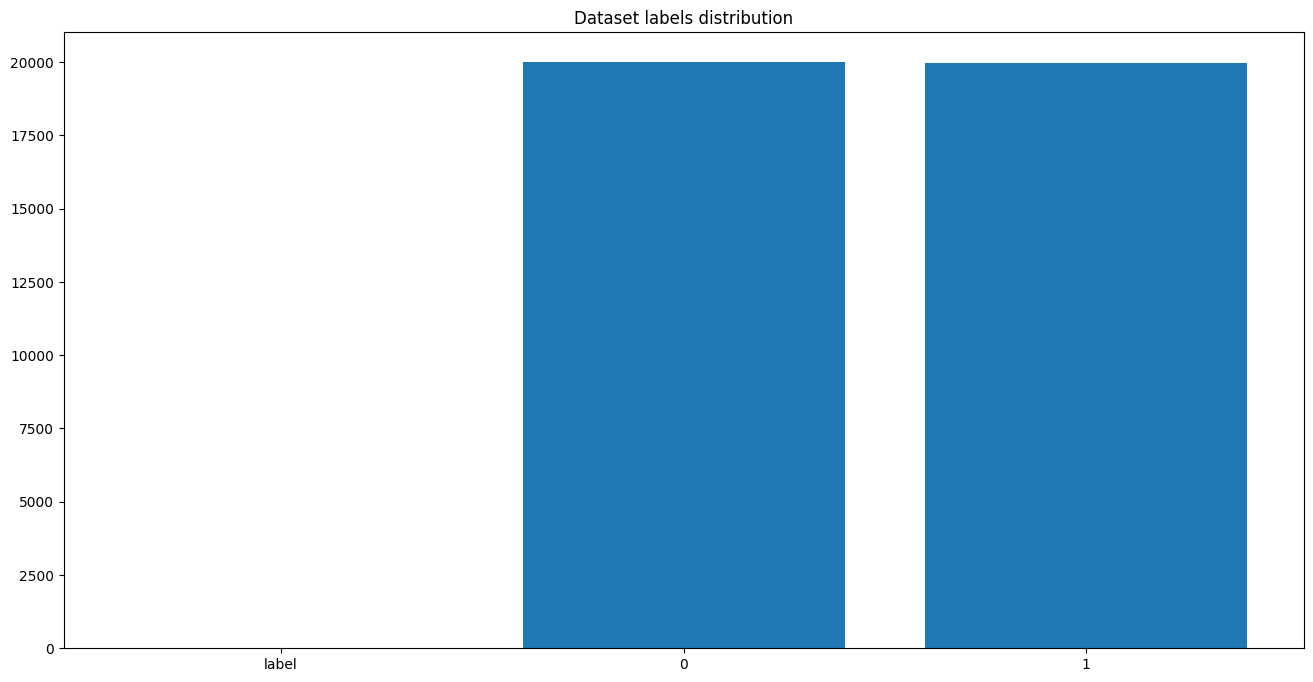

In [70]:
from collections import Counter
import matplotlib.pyplot as plt

target_cnt = Counter(df['target'])

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribution")
plt.show()

### Pre-Process dataset

In [71]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [72]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [73]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 17.1 s, sys: 8.69 ms, total: 17.1 s
Wall time: 17.1 s


### Split train and test

In [74]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 32000
TEST size: 8001


### Word2Vec 

In [75]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 423 ms, sys: 120 ms, total: 543 ms
Wall time: 541 ms


In [76]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [77]:
w2v_model.build_vocab(documents)

In [78]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 22528


In [79]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 10min 9s, sys: 2.47 s, total: 10min 12s
Wall time: 2min 40s


(113568575, 126321504)

In [80]:
w2v_model.wv.most_similar("love")

[('touching', 0.3767949938774109),
 ('loves', 0.3670915961265564),
 ('romantic', 0.3590414822101593),
 ('loved', 0.34750232100486755),
 ('bermuda', 0.3435727655887604),
 ('sadness', 0.33005961775779724),
 ('friendship', 0.32979369163513184),
 ('romance', 0.32582563161849976),
 ('happiness', 0.3235895335674286),
 ('asleep', 0.313664048910141)]

### Tokenize Text

In [81]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 84096
CPU times: user 3.87 s, sys: 219 ms, total: 4.09 s
Wall time: 3.74 s


In [82]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 3.94 s, sys: 14.4 ms, total: 3.95 s
Wall time: 3.95 s


### Label Encoder 

In [83]:
labels = df_train.target.unique().tolist()
labels.append(NEGATIVE)
labels

['0', '1', 'label', 'NEGATIVE']

In [84]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (32000, 1)
y_test (8001, 1)


In [85]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (32000, 300)
y_train (32000, 1)

x_test (8001, 300)
y_test (8001, 1)


In [86]:
y_train[:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]])

### Embedding layer

In [87]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(84096, 300)


In [88]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [89]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          25228800  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 25389301 (96.85 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 25228800 (96.24 MB)
_________________________________________________________________


### Compile model

In [90]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [91]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [92]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 28s 871ms/step - loss: 0.6084 - accuracy: 0.6585 - val_loss: 0.4483 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 2/30
29/29 [==============================] - 25s 862ms/step - loss: 0.4622 - accuracy: 0.7844 - val_loss: 0.5312 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 3/30
29/29 [==============================] - 25s 860ms/step - loss: 0.4018 - accuracy: 0.8237 - val_loss: 0.4771 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 4/30
29/29 [==============================] - 25s 853ms/step - loss: 0.3697 - accuracy: 0.8442 - val_loss: 0.5265 - val_accuracy: 0.7878 - lr: 0.0010
Epoch 5/30
29/29 [==============================] - 25s 852ms/step - loss: 0.3643 - accuracy: 0.8471 - val_loss: 0.4158 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 6/30
29/29 [==============================] - 25s 850ms/step - loss: 0.3559 - accuracy: 0.8489 - val_loss: 0.3790 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 7/30
29/29 [==============================] - 25s 854ms/st

### Evaluate

In [93]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

8/8 [==============================] - 1s 77ms/step - loss: 0.2642 - accuracy: 0.9020

ACCURACY: 0.9020122289657593
LOSS: 0.26424235105514526
CPU times: user 619 ms, sys: 51.8 ms, total: 671 ms
Wall time: 1.33 s


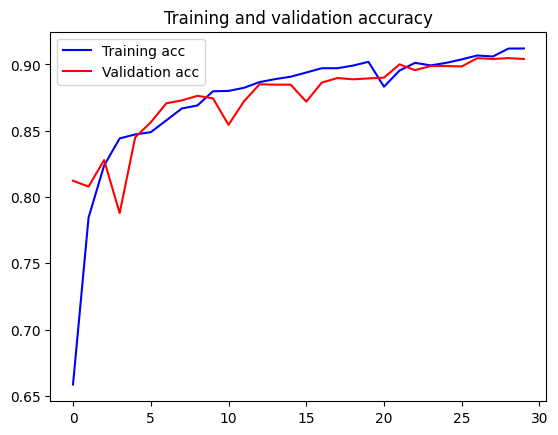

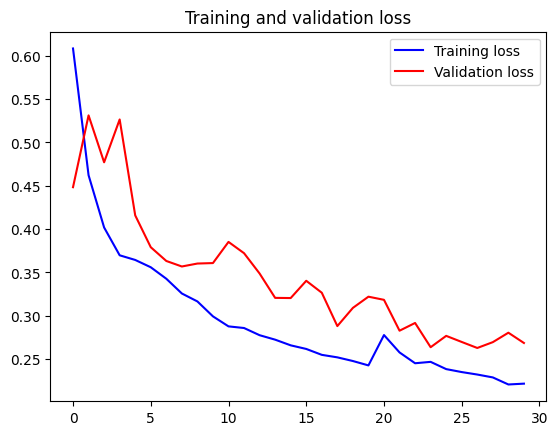

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [95]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.7 else POSITIVE

In [96]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [97]:
predict("I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched")

1/1 [==============================] - 0s 302ms/step


{'label': 'POSITIVE',
 'score': 0.9640738368034363,
 'elapsed_time': 0.3440704345703125}

In [98]:
predict("Why do people who do not know what a particular time in the past was like feel the need to try to de")

1/1 [==============================] - 0s 83ms/step


{'label': 'POSITIVE',
 'score': 0.9153989553451538,
 'elapsed_time': 0.12203335762023926}

In [99]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 93ms/step


{'label': 'POSITIVE',
 'score': 0.8962283730506897,
 'elapsed_time': 0.1323239803314209}

### Confusion Matrix

In [100]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 1s 95ms/step
CPU times: user 608 ms, sys: 127 ms, total: 734 ms
Wall time: 726 ms


In [101]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

/tmp/ipykernel_47/106037557.py:9: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


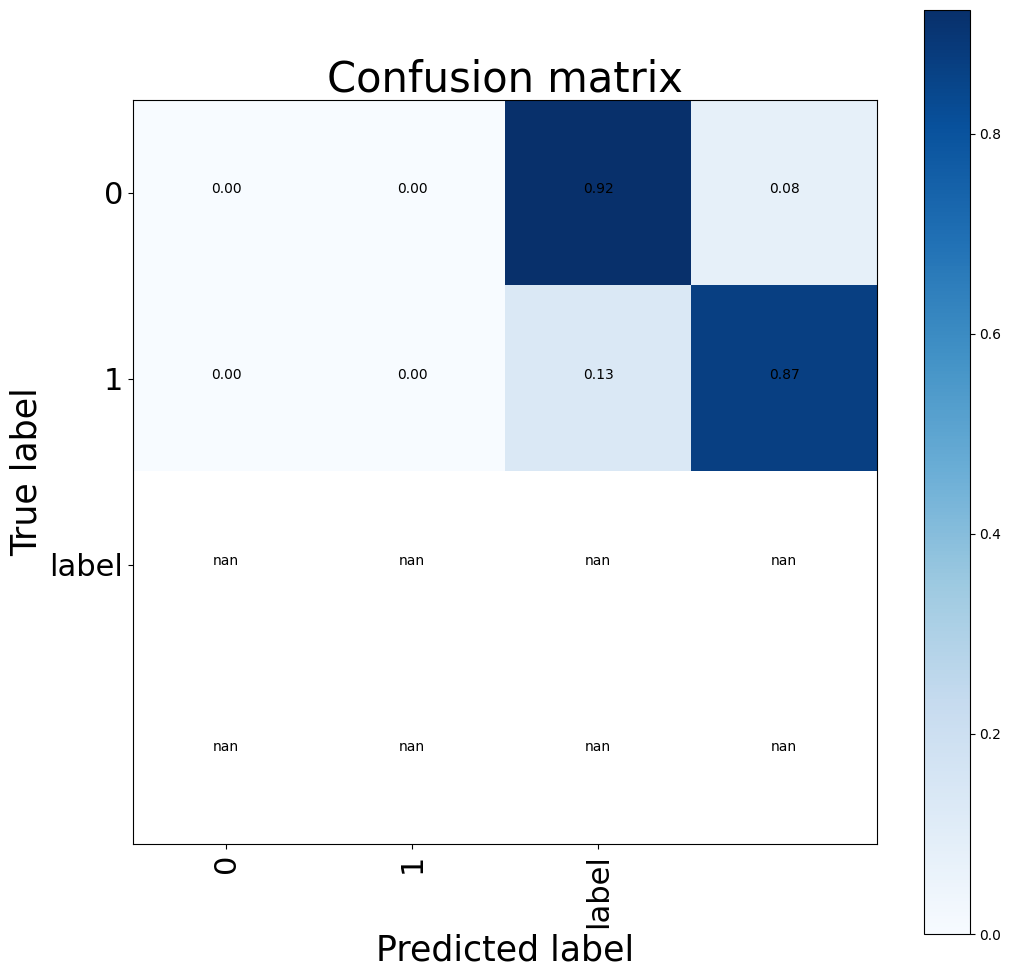

CPU times: user 813 ms, sys: 440 ms, total: 1.25 s
Wall time: 523 ms


In [102]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [103]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    3957.0
           1       0.00      0.00      0.00    4044.0
    NEGATIVE       0.00      0.00      0.00       0.0
    POSITIVE       0.00      0.00      0.00       0.0

    accuracy                           0.00    8001.0
   macro avg       0.00      0.00      0.00    8001.0
weighted avg       0.00      0.00      0.00    8001.0



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

### Accuracy Score

In [104]:
accuracy_score(y_test_1d, y_pred_1d)

0.0

### Save model

In [105]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
